In [1]:
# Imports
import scipy.io
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import os
import hashlib
import requests
import matplotlib.pyplot as plt

In [2]:
# Variables for file and download URL
fname = "condsForSimJ2moMuscles.mat"  # The name of the file to be downloaded
url = "https://osf.io/wak7e/download" # URL from where the file will be downloaded
expected_md5 = "257d16c4d92759d615bf5cac75dd9a1f" # MD5 hash for verifying file integrity

# Check if the file already exists
if not os.path.isfile(fname):
    try:
        # Attempt to download the file
        r = requests.get(url) # Make a GET request to the specified URL
    except requests.ConnectionError:
        # Handle connection errors during the download
        print("!!! Failed to download data !!!")
    else:
        # No connection errors, proceed to check the response
        if r.status_code != requests.codes.ok:
            # Check if the HTTP response status code indicates a successful download
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            # Verify the integrity of the downloaded file using MD5 checksum
            print("!!! Data download appears corrupted !!!")
        else:
            # If download is successful and data is not corrupted, save the file
            with open(fname, "wb") as fid:
                fid.write(r.content) # Write the downloaded content to a file

In [3]:
# Load the .mat file
data = scipy.io.loadmat('condsForSimJ2moMuscles.mat')

# Extract condsForSim struct
conds_for_sim = data['condsForSim']

In [4]:
# Initialize lists to store data for all conditions
go_envelope_all = []
plan_all = []
muscle_all = []

# Get the number of conditions (rows) and delay durations (columns)
num_conditions, num_delays = conds_for_sim.shape

# Loop through each condition and extract data
for i in range(num_conditions):  # 27 conditions
    go_envelope_condition = []
    plan_condition = []
    muscle_condition = []

    for j in range(num_delays):  # 8 delay durations
        condition = conds_for_sim[i, j]

        go_envelope = condition['goEnvelope']
        plan = condition['plan']
        muscle = condition['muscle']

        # Select only muscles 5 and 6 
        selected_muscle_data = muscle[:, [4, 5]]  # which show the nicest multiphasic activity

        go_envelope_condition.append(go_envelope)
        plan_condition.append(plan)
        muscle_condition.append(selected_muscle_data)

    # Convert lists of NumPy arrays to single NumPy arrays before conversion to tensors
    go_envelope_np = np.array(go_envelope_condition)
    plan_np = np.array(plan_condition)
    muscle_np = np.array(muscle_condition)

    # Convert the single NumPy arrays to PyTorch tensors
    go_envelope_all.append(torch.tensor(go_envelope_np, dtype=torch.float32))
    plan_all.append(torch.tensor(plan_np, dtype=torch.float32))
    muscle_all.append(torch.tensor(muscle_np, dtype=torch.float32))

# Stack data for all conditions
go_envelope_tensor = torch.stack(go_envelope_all)
plan_tensor = torch.stack(plan_all)
muscle_tensor = torch.stack(muscle_all)

# Reshape to merge the first two dimensions
go_envelope_tensor = go_envelope_tensor.reshape(-1, *go_envelope_tensor.shape[2:])
plan_tensor = plan_tensor.reshape(-1, *plan_tensor.shape[2:])
muscle_tensor = muscle_tensor.reshape(-1, *muscle_tensor.shape[2:])

# Print shapes
print(f"Go Envelope Tensor Shape: {go_envelope_tensor.shape}")
print(f"Plan Tensor Shape: {plan_tensor.shape}")
print(f"Muscle Tensor Shape: {muscle_tensor.shape}")


Go Envelope Tensor Shape: torch.Size([216, 296, 1])
Plan Tensor Shape: torch.Size([216, 296, 15])
Muscle Tensor Shape: torch.Size([216, 296, 2])


In [5]:
# Normalization and Standardization
def normalize_and_standardize(tensor):
    # Normalize: scale to 0-1 range
    min_val = tensor.min()
    max_val = tensor.max()
    tensor = (tensor - min_val) / (max_val - min_val)

    # Standardize: shift to zero mean and unit variance
    mean = tensor.mean()
    std = tensor.std()
    tensor = (tensor - mean) / std

    return tensor

# Apply normalization and standardization to go_envelope_tensor and plan_tensor
normalized_go_envelope_tensor = normalize_and_standardize(go_envelope_tensor)
normalized_plan_tensor = normalize_and_standardize(plan_tensor)
normalized_muscle_tensor = normalize_and_standardize(muscle_tensor)

# Concatenate normalized tensors along the last dimension
X_train = torch.cat((normalized_go_envelope_tensor, normalized_plan_tensor), dim=2)
y_train = normalized_muscle_tensor

batch_size = 54  # You can adjust this based on your data size and memory constraints
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

In [6]:
# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0)
    
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant
        self.output_linear = nn.Linear(hidden_size, output_size)  # New linear layer

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh    
        
    def forward(self, x, hidden):
        hidden_prev = hidden.clone()
        timestep = self.tau / 10  # Timestep for Euler integration
        # Update hidden state
        hidden_update = torch.matmul(self.J, hidden.transpose(0, 1))
        input_update = torch.matmul(self.B, x.transpose(0, 1))
        new_hidden = self.nonlinearity(hidden_update + input_update + self.bx.unsqueeze(1))
        new_hidden = new_hidden.transpose(0, 1)

        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden + new_hidden)

        # Output calculation
        output = self.output_linear(self.nonlinearity(hidden))

        # Regularization terms
        firing_rate_reg = hidden.pow(2).sum()
        dynamic_reg = (hidden - hidden_prev).pow(2).sum().sqrt()

        return output, hidden, firing_rate_reg, dynamic_reg

    def init_hidden(self, batch_size):
        # Initialize hidden state with batch dimension
        return torch.zeros(batch_size, self.hidden_size)

# Hyperparameters
input_size = 16
hidden_size = 300
output_size = 2  # Number of muscles
g = 1.5  # g value
h = 1.0  # h value

# Model instantiation
model = SimpleRNN(input_size, hidden_size, output_size, g, h)

In [7]:
# Loss Function and Optimizer
criterion = nn.MSELoss()  # MSE Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)


torch.Size([54, 300])
Epoch 1, Loss: 68.0864839553833
Epoch 2, Loss: 45.5173454284668
Epoch 3, Loss: 35.34203910827637
Epoch 4, Loss: 29.13614320755005
Epoch 5, Loss: 24.736980438232422
Epoch 6, Loss: 21.41024112701416
Finished Training
(7104, 54, 300)


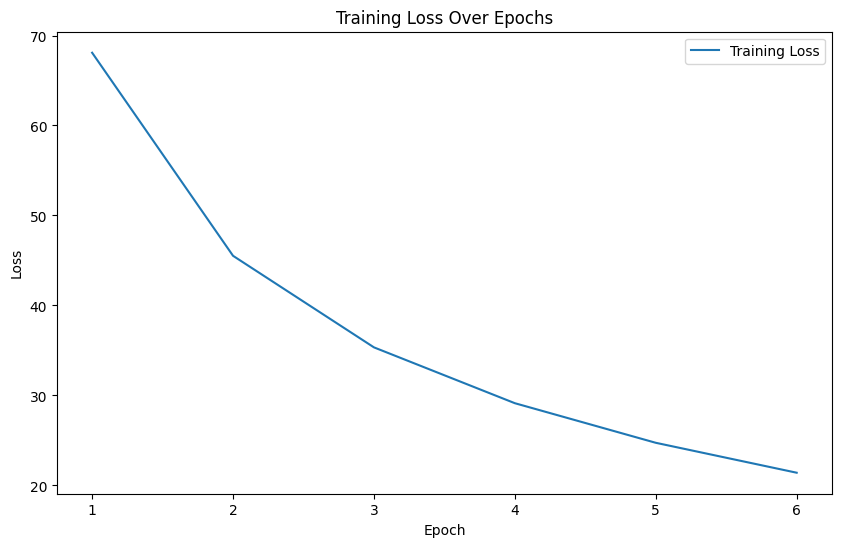

In [8]:
def compute_l2_regularization(parameters, alpha):
    l2_reg = sum(p.pow(2.0).sum() for p in parameters)
    return alpha * l2_reg
    
# Hyperparameters for regularization
alpha = 1e-4  
beta = 0.03
gamma = 1e-4

# Training Loop
num_epochs = 6
epoch_losses = []
batch_size = 54

# Initialize the tensor to accumulate hidden states
accumulated_hidden_states = torch.zeros(batch_size, hidden_size)
print(accumulated_hidden_states.shape)

# Initialize a list to store hidden states for plotting
hidden_states_for_plot = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        batch_size = inputs.size(0)
        h = model.init_hidden(batch_size) # Initialize hidden state with the current batch size
        optimizer.zero_grad()

        total_firing_rate_reg = 0
        total_dynamic_reg = 0

        for t in range(inputs.shape[1]):  # Iterate over time steps
            output, h, firing_rate_reg, dynamic_reg = model(inputs[:, t, :], h)
            hidden_states_for_plot.append(h.detach().cpu().numpy())
            total_firing_rate_reg += firing_rate_reg
            total_dynamic_reg += dynamic_reg
            
        # Convert the list to a NumPy array
        hidden_states_array = np.array(hidden_states_for_plot)
 
        # Reshape to [num_batches, num_time_steps, num_hidden_units]
        hidden_states_array = hidden_states_array.reshape(-1, inputs.shape[1], 300)
        
        # Average across batches
        avg_hidden_states = np.mean(hidden_states_array, axis=0)

        loss = criterion(output, targets[:, -1, :])
        l2_reg = compute_l2_regularization(model.parameters(), alpha)
        rfr_reg = beta * total_firing_rate_reg / inputs.shape[1]  # Average over time steps
        rj_reg = gamma * total_dynamic_reg / inputs.shape[1]  # Average over time steps
    
        total_loss = loss + l2_reg + rfr_reg + rj_reg
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
        running_loss += total_loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

print('Finished Training')

# After training, convert the list of hidden states to a NumPy array for easier manipulation
hidden_states_for_plot = np.array(hidden_states_for_plot)
print(hidden_states_for_plot.shape)

hidden_size = 300  # This should match the hidden size of your RNN

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


In [9]:
# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0)
    
class ComplicatedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(ComplicatedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant

        # Modified weight initialization for a more chaotic regime (g >> 1)
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.w = nn.Parameter(torch.zeros(output_size, hidden_size))
        self.bx = nn.Parameter(torch.zeros(hidden_size))
        self.bz = nn.Parameter(torch.zeros(output_size))

        # Nonlinearity remains the same
        self.nonlinearity = rectified_tanh
    
    def forward(self, x, hidden):
        timestep = self.tau / 10  # Timestep for Euler integration
        for _ in range(int(1 / timestep)):  # Adjust the range for simulation duration
            hidden_update = torch.matmul(self.J, hidden.T)
            input_update = torch.matmul(self.B, x.T)
            new_hidden = self.nonlinearity(hidden_update + input_update + self.bx.unsqueeze(1))
            new_hidden = new_hidden.T

            # Euler integration for continuous-time update
            hidden = hidden + (timestep / self.tau) * (-hidden + new_hidden)
        
        output = torch.matmul(self.w, hidden.T) + self.bz.unsqueeze(1)
        output = output.T
    
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

input_size = 7
hidden_size = 300
output_size = 2 # Number of muscles
g = 4 # Significantly larger g value for complicated model
h = 1.0 # h value remains the same

complicated_model = ComplicatedRNN(input_size, hidden_size, output_size, g, h)

In [11]:
# Training Loop
num_epochs = 5  # The number of epochs
epoch_losses = []  # To store average loss per epoch
optimizer2 = optim.Adam(model.complicated_parameters(), lr=0.001, weight_decay=0)

for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, targets in train_loader:
        optimizer2.zero_grad()
        batch_size = inputs.size(0)
        h = complicated_model.init_hidden(batch_size)

        total_loss = 0.0  # Accumulate loss over time steps

        for t in range(inputs.shape[1]):
            output, h = complicated_model(inputs[:, t, :], h)
            loss = criterion(output, targets[:, t, :])  # Compute loss at each time step
            total_loss += loss

        total_loss.backward()  # Backpropagation on the accumulated loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer2.step()

        running_loss += total_loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

print('Finished Training')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


AttributeError: 'SimpleRNN' object has no attribute 'complicated_parameters'

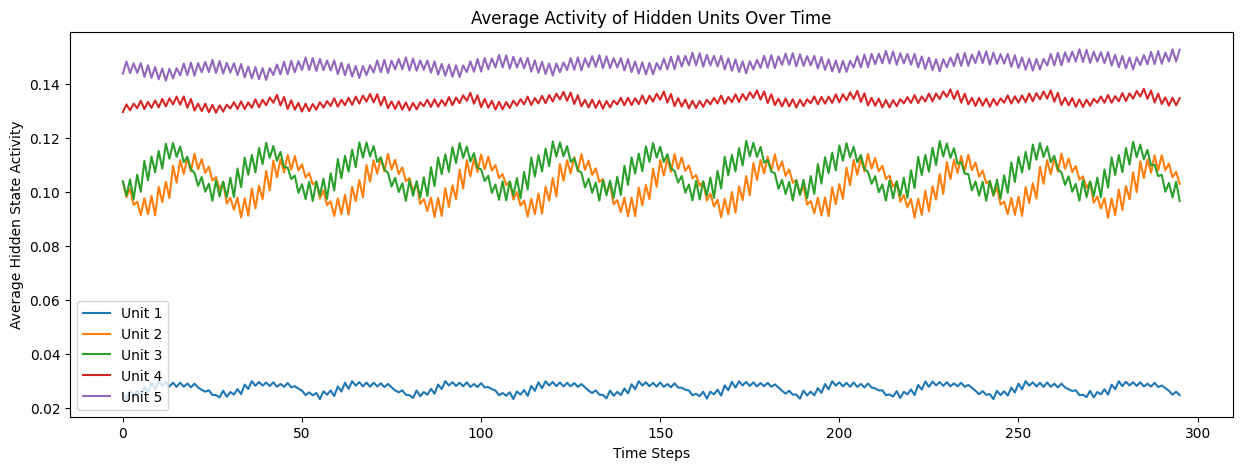

In [13]:
# Plot hidden units of the Simple RNN

plt.figure(figsize=(15, 5))
for i in range(5):  # Iterate over five hidden units
    plt.plot(avg_hidden_states[:, i], label=f'Unit {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Average Hidden State Activity')
plt.title('Average Activity of Hidden Units Over Time')
plt.legend()
plt.show()

In [ ]:
# Function to add gaussian noise to the input data.
def perturb_inputs(inputs, noise_level=0.1):
    # Generating noise with the same shape as inputs
    noise = torch.randn_like(inputs) * noise_level
    # Adding the generated noise to the inputs and returning the noisy inputs
    return inputs + noise

# Function to add noise to the weights of a neural network model
def perturb_weights(model, perturbation_factor=0.1):
    # Iterating over all parameters (weights and biases) of the model
    for param in model.parameters():
        # Checking if the parameter is trainable 
        if param.requires_grad:
            # Adding in-place Gaussian noise to the parameter
            param.data.add_(torch.randn_like(param) * perturbation_factor)

# Function to evaluate the model's performance on a dataset
def evaluate_model(model, data_loader, criterion, complicated=False):
    # Setting the model to evaluation mode
    model.eval()
    total_loss = 0.0
    # Disabling gradient calculation as it's not needed during evaluation
    with torch.no_grad():
        # Iterating through the dataset using the data loader
        for inputs, targets in data_loader:
            # Determining the batch size from the input shape
            batch_size = inputs.size(0)
            # Initializing the hidden state of the model for the current batch
            # Iterating over each time step in the input sequence
            for t in range(inputs.shape[1]):
                # Conditionally handling the model's forward pass based on the 'complicated' flag
                if complicated:
                    h = model.init_hidden(batch_size)
                    # For a 'complicated' model, forward pass with the current timestep's input and hidden state.
                    output, h = model(inputs[:, t, :], h)
                else:
                    h = model.init_hidden(batch_size)
                    # For a simpler model, forward pass with additional unused outputs
                    output, h, _, _ = model(inputs[:, t, :], h)
                    # Calculating the loss between the model output and the target for the last timestep
                    loss = criterion(output, targets[:, -1, :])
                    # Accumulating the loss for the current batch
                    total_loss += loss.item()
                    # Returning the average loss across all batches in the data loader
                return total_loss / len(data_loader)
                
def assess_robustness(model, data_loader, criterion, perturb_function, perturbation_level, complicated=False):
    # Evaluate on non-perturbed data
    original_loss = evaluate_model(model, data_loader, criterion, complicated)
    # Perturb model
    perturb_function(model, perturbation_level)
    # Evaluate on perturbed data
    perturbed_loss = evaluate_model(model, data_loader, criterion, complicated)
    return original_loss, perturbed_loss

In [ ]:
# Evaluate and compare robustness
simple_original_loss, simple_perturbed_loss = assess_robustness(model, train_loader, criterion, perturb_weights, 0.1)
complex_original_loss, complex_perturbed_loss = assess_robustness(complicated_model, train_loader, criterion, perturb_weights, 0.1, complicated=True)

print(f"Simple Model - Original Loss: {simple_original_loss}, Perturbed Loss: {simple_perturbed_loss}")
print(f"Complex Model - Original Loss: {complex_original_loss}, Perturbed Loss: {complex_perturbed_loss}")
